In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path
import torch
import ssm
from dynamax.hidden_markov_model import LinearAutoregressiveHMM,GaussianHMM 
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation
from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer


In [46]:
path = "/Users/mds8301/Desktop/temp/dopamine_full_timeseries_array.pt"

data = AADataLoader(path)
data.load_data()
data.prepare_data()

In [47]:
data.labels

array([1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 0., 0.], dtype=float32)

In [48]:
len(data.x[0])

150347

In [49]:

num_states = 4
emission_dim = 1

model = ssm.HMM(num_states,emission_dim, method = 'ar',transitions='sticky', observations='gaussian')

In [50]:
lls = model.fit(data.x, method= "em", num_iters = 10)

# zhat = arhmm.most_likely_states(x_sample)

  0%|          | 0/10 [00:00<?, ?it/s]

In [53]:
anlz = ARHMMAnalyzer(model,lls, data.x, data.labels)


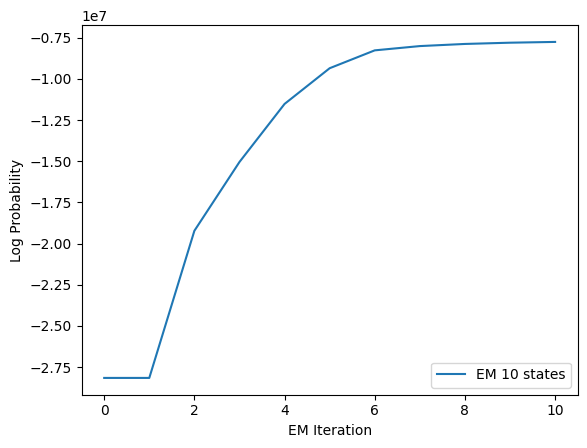

In [54]:
lls_plot = anlz.plot_lls()

In [55]:
anlz.compute_metrics()

-2.2020319 5.57938


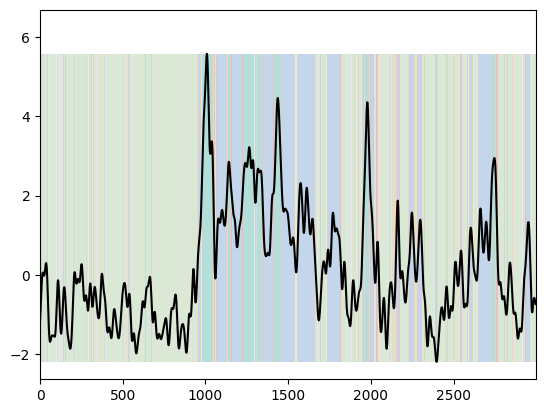

In [56]:
states_plt = anlz.plot_states()


<Axes: xlabel='state', ylabel='mean_duration'>

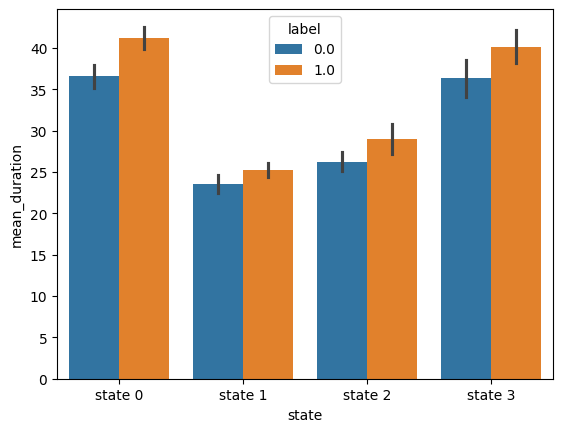

In [57]:
anlz.plot_mean_state_duration()

(-2.591102457046509, 5.96845064163208)

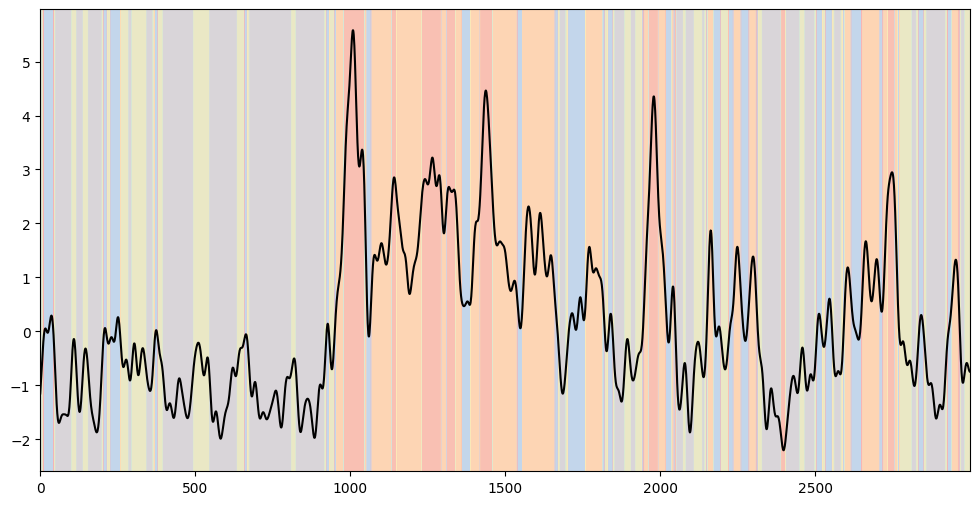

In [119]:
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "teal",
    "coral",
    "light blue",
    "sage green"
]

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Ensure we have enough colors for all states
idx = 1
x_s = x_arr[idx][:3000]
z_s = z_hat_arr[idx][:3000]

# Adjust the plot to cover the full vertical range of x_s
y_min, y_max = x_s.min(), x_s.max()
y_range = y_max - y_min
y_padding = 0.05 * y_range  # Add 5% padding on top and bottom

plt.figure(figsize=(12,6))
plt.plot(x_s, c='k')
plt.imshow(z_s[None,:], cmap=cmap, aspect='auto', extent=[0, len(x_s)-1, y_min-y_padding, y_max+y_padding], alpha=0.3)
plt.ylim(y_min-y_padding, y_max+y_padding)


In [180]:

def get_mean_durations(z_hat, num_states):
    state_lst, state_dur = ssm.util.rle(z_hat)
    dur_stack =[]
    for s in range(num_states):
        dur_stack.append(state_dur[state_lst==s])
    return {f'state {s}': np.mean(v) for s,v in zip(range(num_states), dur_stack)}


def compile_mean_data(label, z_hat, num_states,):
    data_dict = get_mean_durations(z_hat, num_states)
    data_dict['label']=float(label)
    return data_dict


def aggregate_mean_data(label_arr, z_hat_arr, num_states):

    agg_data = [compile_mean_data(l, z, 5) for l,z in zip(labels, z_hat)]
    agg_data_df = (pl.concat([pl.DataFrame(d) for d in agg_data], how='vertical')
                   .melt(id_vars='label', variable_name='state', value_name='mean_duration')
    )
    return agg_data_df
agg_data_df = aggregate_mean_data(labels, z_hat, 4)

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_70764/1055263958.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_dict['label']=float(label)
/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_70764/1055263958.py:19: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars='label', variable_name='state', value_name='mean_duration')


<Axes: xlabel='state', ylabel='mean_duration'>

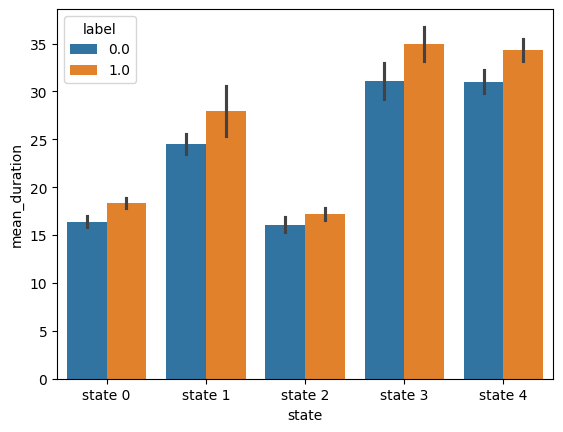

In [300]:
sns.barplot(agg_data_df.to_pandas(), x='state', y='mean_duration', hue='label', errorbar='se')